In [107]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import ml_utils.road_seg as rs
import ml_utils.model as model
import ml_utils.data_augmentation as d_aug
import ml_utils.postprocess as pproc

path_data = 'data'
path_train_dir = os.path.join(path_data, 'training')
path_test = os.path.join(path_data, 'test_set_images')
path_models = 'model'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Model training


In [108]:
m = model.Model(model_type='cnn_bn')

conv1_1 size (?, ?, ?, 64)
conv1_2 size (?, ?, ?, 64)
conv1_3 size (?, ?, ?, 64)
pool1 size (?, ?, ?, 64)
conv2_1 size (?, ?, ?, 64)
conv2_2 size (?, ?, ?, 64)
conv2_3 size (?, ?, ?, 64)
pool2 size (?, ?, ?, 64)
conv3_1 size (?, ?, ?, 64)
conv3_2 size (?, ?, ?, 64)
conv3_3 size (?, ?, ?, 64)
pool3 size (?, ?, ?, 64)
conv4_1 size (?, ?, ?, 64)
conv4_2 size (?, ?, ?, 64)
conv4_3 size (?, ?, ?, 64)
pool4 size (?, ?, ?, 64)
conv5_1 size (?, ?, ?, 64)
conv5_2 size (?, ?, ?, 64)
deconv1 size (?, ?, ?, 64)
deconv1_c size (?, ?, ?, 128)
conv6_1 size (?, ?, ?, 96)
conv6_2 size (?, ?, ?, 64)
deconv2 size (?, ?, ?, 64)
deconv2_c size (?, ?, ?, 128)
conv7_1 size (?, ?, ?, 96)
conv7_2 size (?, ?, ?, 64)
deconv3 size (?, ?, ?, 64)
deconv3_c size (?, ?, ?, 128)
conv8_1 size (?, ?, ?, 96)
conv8_2 size (?, ?, ?, 64)
deconv4 size (?, ?, ?, 64)
deconv4_c size (?, ?, ?, 128)
conv9_1 size (?, ?, ?, 96)
conv9_2 size (?, ?, ?, 64)
score size (?, ?, ?, 2)


In [ ]:
m.train_model(path_train_dir, n_epoch=150, display_epoch=5, nmax=10, n_aug=400, n_worst=50, ratio=1.0)

In [ ]:
m.plot_stats('model/submission_model_stats.npy')

# 2. Train/Validation vizualisation


In [109]:
file_save = 'model/submission_model.ckpt'
m = model.Model(model_type='cnn_bn')

conv1_1 size (?, ?, ?, 64)
conv1_2 size (?, ?, ?, 64)
conv1_3 size (?, ?, ?, 64)
pool1 size (?, ?, ?, 64)
conv2_1 size (?, ?, ?, 64)
conv2_2 size (?, ?, ?, 64)
conv2_3 size (?, ?, ?, 64)
pool2 size (?, ?, ?, 64)
conv3_1 size (?, ?, ?, 64)
conv3_2 size (?, ?, ?, 64)
conv3_3 size (?, ?, ?, 64)
pool3 size (?, ?, ?, 64)
conv4_1 size (?, ?, ?, 64)
conv4_2 size (?, ?, ?, 64)
conv4_3 size (?, ?, ?, 64)
pool4 size (?, ?, ?, 64)
conv5_1 size (?, ?, ?, 64)
conv5_2 size (?, ?, ?, 64)
deconv1 size (?, ?, ?, 64)
deconv1_c size (?, ?, ?, 128)
conv6_1 size (?, ?, ?, 96)
conv6_2 size (?, ?, ?, 64)
deconv2 size (?, ?, ?, 64)
deconv2_c size (?, ?, ?, 128)
conv7_1 size (?, ?, ?, 96)
conv7_2 size (?, ?, ?, 64)
deconv3 size (?, ?, ?, 64)
deconv3_c size (?, ?, ?, 128)
conv8_1 size (?, ?, ?, 96)
conv8_2 size (?, ?, ?, 64)
deconv4 size (?, ?, ?, 64)
deconv4_c size (?, ?, ?, 128)
conv9_1 size (?, ?, ?, 96)
conv9_2 size (?, ?, ?, 64)
score size (?, ?, ?, 2)


## 2.1. Layers vizualisation

In [213]:
train_imgs, train_gt, val_imgs, val_gt = m._get_base_sets(ratio=1.0)
train_imgs, _, _ = rs.normalize_data(train_imgs, mode='all', mean_ref = m.mean, std_ref = m.std) 

In [214]:
layers, labels = m.get_model_layers(train_imgs[0], file_save)

INFO:tensorflow:Restoring parameters from model/submission_model.ckpt


In [215]:
train_imgs, train_gt, val_imgs, val_gt = m._get_base_sets(ratio=1.0)

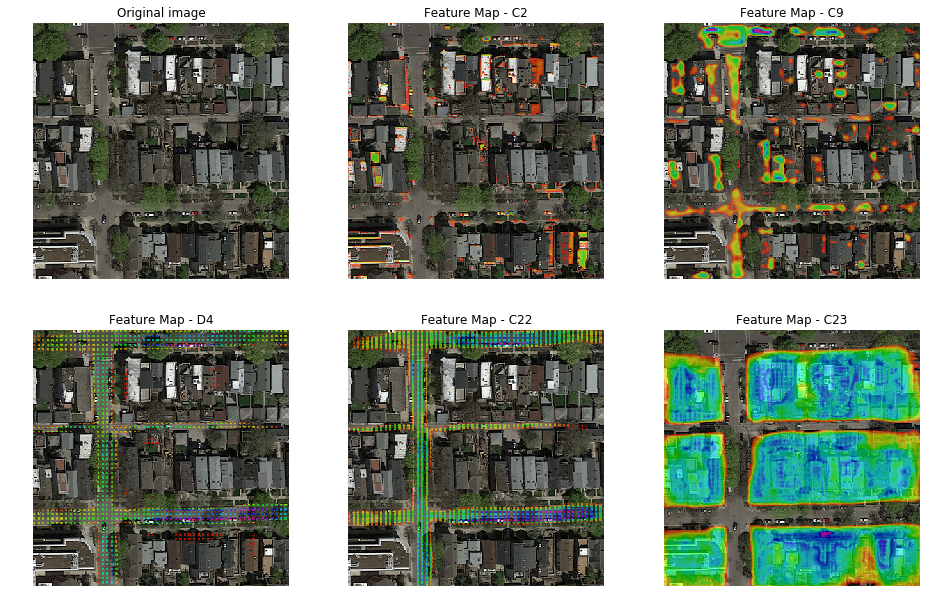

In [229]:
from skimage.transform import resize
                
plt.figure(figsize=(16,16))
ax = plt.subplot(3,3,1)
ax.imshow(train_imgs[0]); ax.axis('off'); ax.set_title('Original image')

for i, l in enumerate(layers):
    ax = plt.subplot(3,3,2+i)
    max_vals = np.max(l, axis=(1,2))
    id_max = np.argmax(max_vals)
    res = resize(l[0, :, :, id_max]/np.max(l), (400, 400), mode='constant')
    masked = np.ma.masked_where(res < 0.1, res)
    ax.imshow(train_imgs[0]); ax.imshow(masked, alpha=0.6, cmap='hsv')
    ax.axis('off'); ax.set_title('Feature Map - {}'.format(labels[i]))

## 2.2. Results vizualisation

In [217]:
y_pred_train = m.apply_model(train_imgs, file_save)
print('F1-score train: {}'.format(m.predict_f1(train_gt, y_pred_train)))
print('F1-score train kaggle: {}'.format(m.predict_f1_kaggle(train_gt, y_pred_train)))

INFO:tensorflow:Restoring parameters from model/submission_model.ckpt
0/100
5/100
10/100
15/100
20/100
25/100
30/100
35/100
40/100
45/100
50/100
55/100
60/100
65/100
70/100
75/100
80/100
85/100
90/100
95/100
F1-score train: 0.09602904401795667


IndexError: tuple index out of range

In [ ]:
train_imgs, train_gt, val_imgs, val_gt = m._get_base_sets(ratio=1.0)
rs.display_predictions(y_pred_train, train_imgs, train_gt, n_display=5)

In [ ]:
#y_pred_valid = m.apply_model(val_imgs, file_save)
#print('F1-score validation: {}'.format(m.predict_f1(val_gt, y_pred_valid)))
#print('F1-score validation kaggle: {}'.format(m.predict_f1_kaggle(val_gt, y_pred_valid)))

In [ ]:
#rs.display_predictions(y_pred_valid, val_imgs, val_gt, n_display=5)

## 2.3. Post process

In [ ]:
pred_proc = pproc.process_all(y_pred_train)

print('F1-score train: {}'.format(m.predict_f1(train_gt, pred_proc)))
print('F1-score train kaggle: {}'.format(m.predict_f1_kaggle(train_gt, pred_proc)))

In [ ]:
#pred_proc = pproc.process_all(y_pred_valid)

#print('F1-score validation: {}'.format(m.predict_f1(val_gt, pred_proc)))
#print('F1-score validation kaggle: {}'.format(m.predict_f1_kaggle(val_gt, pred_proc)))

# 4. Train set

In [ ]:
test_img = rs.load_test_set(path_test)
test_img_norm, _, _ = rs.normalize_data(test_img, mode='all', mean_ref=m.mean, std_ref=m.std)

In [ ]:
# m = model.Model(model_type='cnn_bn', display_log=False)
y_pred_test = m.apply_model(test_img_norm, file_save, nmax=2)

In [ ]:
y_pred_test_proc = pproc.process_all(y_pred_test, size_image=608)

In [ ]:
im_proc = np.reshape(y_pred_test_proc, (-1, 608, 608))
im_base = np.reshape(y_pred_test, (-1, 608, 608))
rs.display_predictions(y_pred_test, test_img, im_proc, n_display=50)

In [ ]:
from skimage.morphology import skeletonize, thin, skeletonize_3d
from skimage import data
import matplotlib.pyplot as plt
from skimage.morphology import disk, closing, opening, remove_small_objects, dilation
from skimage.measure import label, regionprops
import numpy as np
import scipy
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)

img = im_base[4]


r = closing(img, disk(5))
r = remove_small_objects(r.astype(bool), min_size = 200)

corr = skeletonize_3d(r.astype(np.uint8))


k = np.array([[1,1,1],[1,0,1],[1,1,1]])
k = scipy.ndimage.filters.convolve(corr, k, mode='constant', cval=0.0)

end_line = np.logical_and(k == 1, corr)

lines = probabilistic_hough_line(corr, threshold=10, line_length=5, line_gap=3)

In [ ]:
fig, ax = plt.subplots(2,3, figsize=(16,10))

ax[0,0].imshow(img)
ax[0,1].imshow(dilation(corr, disk(1)))
ax[0,2].imshow(dilation(end_line, disk(3)));
ax[1,0].imshow(test_img[5])

for line in lines:
    p0, p1 = line
    ax[0,1].plot((p0[0], p1[0]), (p0[1], p1[1]))

# 4. Submission

In [ ]:
rs.create_submission(im_proc, 'test_150epoch_full.csv')